<br>

I used ResNet architecture with the imagenet weights.

<br>

## Predictions

<br>

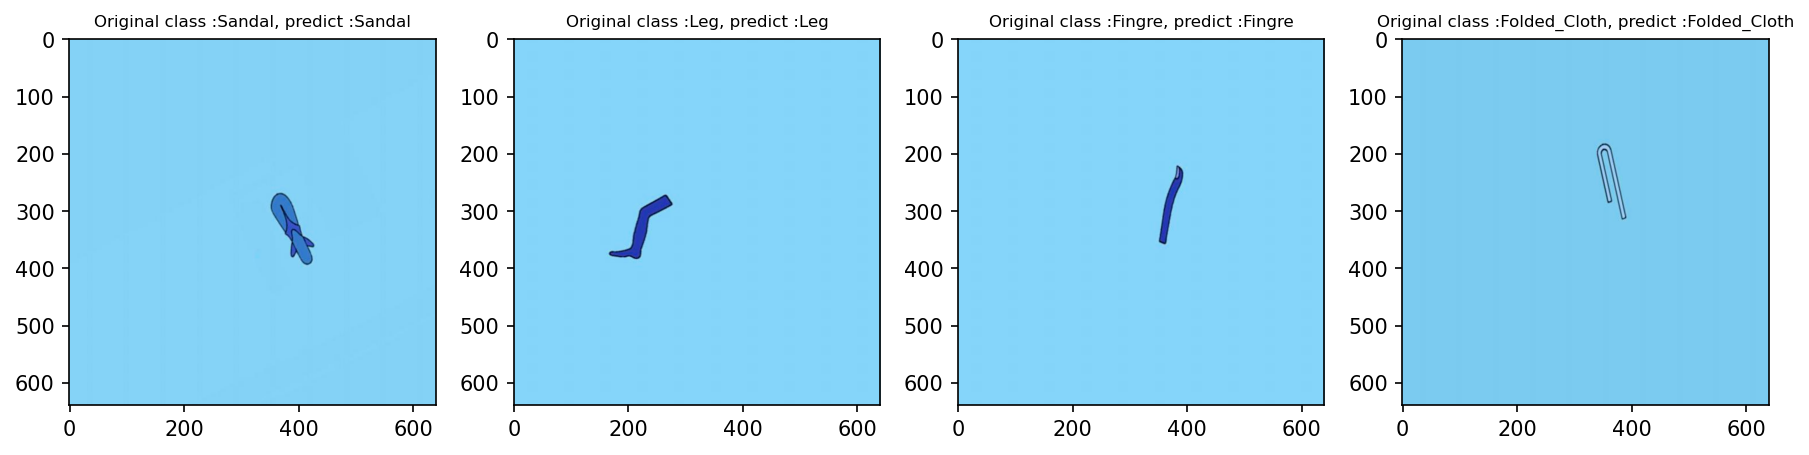


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import random

from sklearn.metrics import classification_report, confusion_matrix,average_precision_score

from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D,BatchNormalization, Activation,Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(10)

In [ ]:
train_data = pd.read_csv('C:\\Users\\abdelrahman farraag\\Downloads\\pp\\archive (2)\\train\\_annotations.csv')
val_data = pd.read_csv('C:\\Users\\abdelrahman farraag\\Downloads\\pp\\archive (2)\\valid\\_annotations.csv')
test_data = pd.read_csv('C:\\Users\\abdelrahman farraag\\Downloads\\pp\\archive (2)\\test\\_annotations.csv')

In [ ]:
oe = OrdinalEncoder()

# Encoding class labels in the train set
main_path_train = 'C:\\Users\\abdelrahman farraag\\Downloads\\pp\\archive (2)\\train/'
train_data['filename'] = train_data['filename'].apply(lambda x: main_path_train + x)

oe.fit(np.array(train_data['class']).reshape(-1,1))
train_data['class'] = oe.transform(np.array(train_data['class']).reshape(-1,1))

# Encoding class labels in the validation set
main_path_val = 'C:\\Users\\abdelrahman farraag\\Downloads\\pp\\archive (2)\\valid/'
val_data['filename'] = val_data['filename'].apply(lambda x: main_path_val + x)
val_data['class'] = oe.transform(np.array(val_data['class']).reshape(-1,1))


# Encoding class labels in the test set
main_path_test = 'C:\\Users\\abdelrahman farraag\\Downloads\\pp\\archive (2)\\test/'
test_data['filename'] = test_data['filename'].apply(lambda x: main_path_test + x)
test_data['class'] = oe.transform(np.array(test_data['class']).reshape(-1,1))

In [ ]:
# Creating random 3 sample from a dataframe

def create_random_samples(data):
    fig, axs = plt.subplots(1,3, figsize = (12,5), dpi = 130)
    
    idx1 = random.randint(0,data.shape[0])
    img1 = cv2.imread(data['filename'][idx1])
    name1 = oe.inverse_transform(np.array(data['class'][idx1]).reshape(-1,1))[0][0]
    
    idx2 = random.randint(0,data.shape[0])
    img2 = cv2.imread(data['filename'][idx2])
    name2 = oe.inverse_transform(np.array(data['class'][idx2]).reshape(-1,1))[0][0]
    
    idx3 = random.randint(0,data.shape[0])
    img3 = cv2.imread(data['filename'][idx3])
    name3 = oe.inverse_transform(np.array(data['class'][idx3]).reshape(-1,1))[0][0]
    
    
    axs[0].imshow(img1)
    axs[0].set_title(name1)

    axs[1].imshow(img2)
    axs[1].set_title(name2)
    
    axs[2].imshow(img3)
    axs[2].set_title(name3)
    
    
    plt.show()

In [ ]:
# Training samples

create_random_samples(train_data)

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [ ]:
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (250,250))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label
    

In [ ]:
BATCH_SIZE = 32

train_loader = tf.data.Dataset.from_tensor_slices((train_data['filename'], train_data['class']))
train_dataset = (train_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(train_data.shape[0]).prefetch(BATCH_SIZE) )

val_loader = tf.data.Dataset.from_tensor_slices((val_data['filename'], val_data['class']))
val_dataset = (val_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(val_data.shape[0]).prefetch(BATCH_SIZE) )

test_loader = tf.data.Dataset.from_tensor_slices((test_data['filename'], test_data['class']))
test_dataset = (test_loader.map(img_preprocessing).batch(BATCH_SIZE).prefetch(BATCH_SIZE) )

# <span style="color:#e74c3c;"> DenseNet </span> Model


In [ ]:
pretrained_model = tf.keras.applications.DenseNet169(weights='imagenet',include_top=False ,input_shape=[250,250, 3])
pretrained_model.trainable = True

model = tf.keras.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.1),
    
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.1),
    
    Dense(len(oe.categories_[0]), activation = 'softmax') #nclasses = 95
    
])

model.compile(optimizer  = tf.keras.optimizers.Adam(learning_rate = 0.00001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.summary()

# <span style="color:#e74c3c;"> Training </span> 


In [ ]:
hist = model.fit(train_dataset, epochs = 8 , validation_data = val_dataset, callbacks = [EarlyStopping(min_delta =0.0001, patience = 2)])

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (10,5), dpi = 120)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Accuracy")
axs[0].plot(hist.history['accuracy'])
axs[0].plot(hist.history['val_accuracy'])
axs[0].legend(["train", "validation"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Loss")
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].legend(["train", "validation"])

# <span style="color:#e74c3c;"> Evaluation </span> 


In [ ]:
test_eval = model.evaluate(test_dataset)
print('test accuracy : {0:.3f} %'.format(test_eval[1]*100))

# <span style="color:#e74c3c;"> Prediction </span> 


In [ ]:
pred = model.predict(test_dataset)
pred_ = np.argmax(pred, axis = 1)

In [ ]:
# Classification report 

report = classification_report(np.array(test_data['class']), pred_)
print(report)

In [ ]:
# Creating random 3 sample from a dataframe

def create_random_samples_and_prediction(data,pred):
    fig, axs = plt.subplots(1,4, figsize = (12,5), dpi = 150)
    
    idx1 = random.randint(0,data.shape[0])
    img1 = cv2.imread(data['filename'][idx1])
    name1 = oe.inverse_transform(np.array(data['class'][idx1]).reshape(-1,1))[0][0]
    pred1 = oe.inverse_transform(np.array(pred[idx1]).reshape(-1,1))[0][0]
    
    idx2 = random.randint(0,data.shape[0])
    img2 = cv2.imread(data['filename'][idx2])
    name2 = oe.inverse_transform(np.array(data['class'][idx2]).reshape(-1,1))[0][0]
    pred2 = oe.inverse_transform(np.array(pred[idx2]).reshape(-1,1))[0][0]

    idx3 = random.randint(0,data.shape[0])
    img3 = cv2.imread(data['filename'][idx3])
    name3 = oe.inverse_transform(np.array(data['class'][idx3]).reshape(-1,1))[0][0]
    pred3 = oe.inverse_transform(np.array(pred[idx3]).reshape(-1,1))[0][0]
    
    idx4 = random.randint(0,data.shape[0])
    img4 = cv2.imread(data['filename'][idx4])
    name4 = oe.inverse_transform(np.array(data['class'][idx4]).reshape(-1,1))[0][0]
    pred4 = oe.inverse_transform(np.array(pred[idx4]).reshape(-1,1))[0][0]

    
    axs[0].imshow(img1)
    axs[0].set_title("Original class :" + name1 + ", predict :" + pred1, fontsize=8 )

    axs[1].imshow(img2)
    axs[1].set_title("Original class :" + name2 + ", predict :" + pred2, fontsize=8 )
    
    axs[2].imshow(img3)
    axs[2].set_title("Original class :" + name3 + ", predict :" + pred3, fontsize=8 )
    
    axs[3].imshow(img4)
    axs[3].set_title("Original class :" + name4 + ", predict :" + pred4, fontsize=8 )
    
    fig.tight_layout()
    plt.show()

In [ ]:
# Original and prediction examples

create_random_samples_and_prediction(test_data, pred_ )